## PROJECT 2

### Personalized E-Commerce Engagement System 
### Submitted By : Vivek Giri

#### Objective
The __Personalized E-Commerce Engagement System__ addresses this critical business problem by leveraging granular transactional data to transition from aggregate reporting to individualized engagement. 
The primary objective is to determine how a retailer can programmatically identify high-value wholesalers, nurture casual shoppers, and re-engage dormant customers at risk of churn. By solving this, the business can optimize its marketing spend and maximize the lifetime value (LTV) of every customer in its database.

#### Data Preparation 

In data preparation, 135,080 rows were removed due to missing Customer IDs. Furthermore, the analysis filtered out transactions with negative quantities, which represented returns or cancellations, as well as items with a unit price of zero. The final cleaned dataset consisted of 392,692 valid transactions

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import datetime as dt
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")



In [9]:
# --- Step 1: Data Loading & Cleaning ---
# Load the dataset with correct encoding
df = pd.read_csv('/Users/vivekgiri/Downloads/DSC680- Vivek/Customer Segmentation & Recommendation System/data.csv', encoding='ISO-8859-1')

# Cleaning pipeline: remove missing IDs, duplicates, cancellations, and non-positive values
df = df.dropna(subset=['CustomerID'])
df = df.drop_duplicates()
df = df[~df['InvoiceNo'].str.contains('C', na=False)]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Dataset cleaned. Remaining rows: {df.shape[0]}")



Dataset cleaned. Remaining rows: 392692


#### RFM (Recency, Frequency, Monetary) analysis 

Recency measures the days since the last purchase, Frequency counts the total number of transactions, and Monetary Value calculates the total revenue per customer. Because these metrics exhibit heavy right-tail skew, a log transformation was applied to normalize the distributions. Subsequently, the data were scaled using a StandardScaler to ensure the K-Means algorithm treated each metric equally.

In [10]:
# --- Step 2: RFM Feature Engineering ---
# Calculate Total Sum per line item
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# Define snapshot date for Recency (one day after the last recorded transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate data to Customer level
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSum': 'Monetary'})

print("RFM Features created. Sample:")
print(rfm.head())



RFM Features created. Sample:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


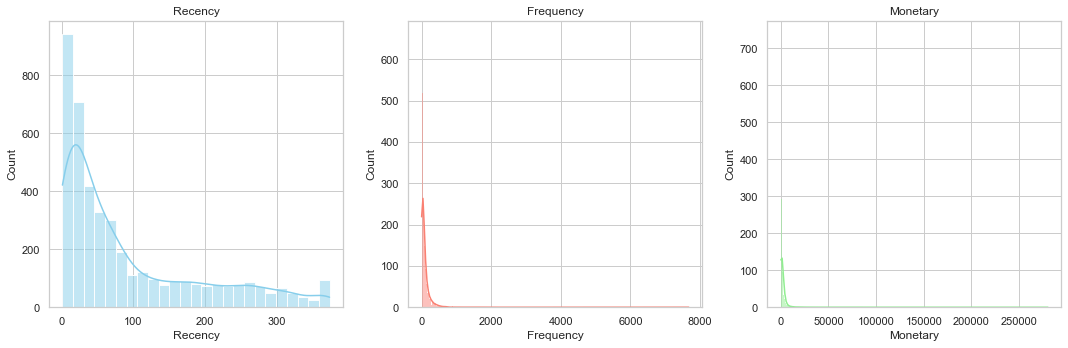

In [11]:
# --- Step 3: Distribution Visualization ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True, color='skyblue').set_title('Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True, color='salmon').set_title('Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=True, color='lightgreen').set_title('Monetary')
plt.tight_layout()
plt.show()



In [12]:
# --------- Step 4: Data Transformation & Scaling ---------

# Log transform to handle right-skewness and scale for K-Means
rfm_log = np.log1p(rfm)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)



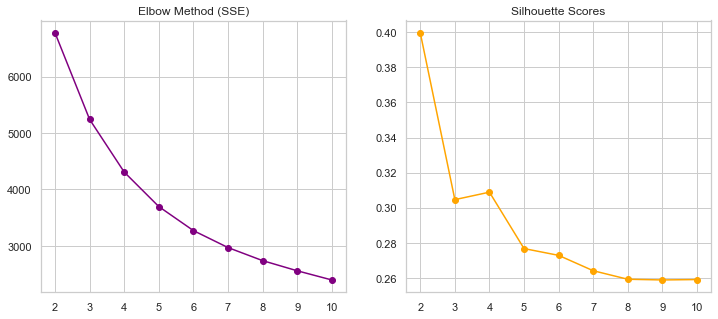

In [13]:
# ---------- Step 5: Finding Optimal Clusters ---------

sse = {}
sil = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    sse[k] = km.inertia_
    sil.append(silhouette_score(rfm_scaled, km.labels_))

# Plot Elbow and Silhouette results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='purple')
plt.title('Elbow Method (SSE)')
plt.subplot(1, 2, 2)
plt.plot(k_range, sil, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.show()



In [14]:
# --------- Step 6: K-Means Implementation (K=3) ------------

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Assign behavioral labels based on cluster means
stats = rfm.groupby('Cluster')['Monetary'].mean().sort_values(ascending=False)
mapping = {stats.index[0]: 'Champions', stats.index[1]: 'Loyal/Potential', stats.index[2]: 'At Risk'}
rfm['Segment'] = rfm['Cluster'].map(mapping)



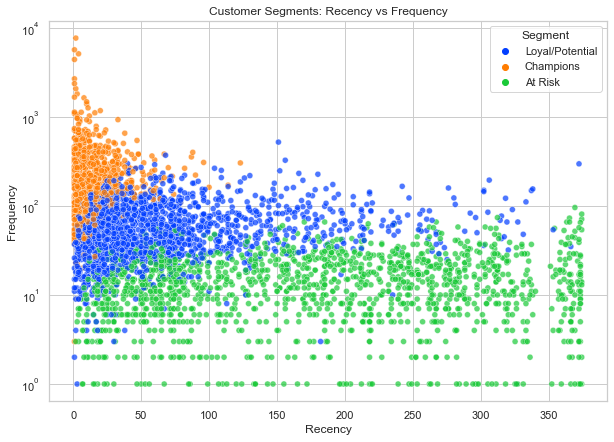

In [15]:
# --------- Step 7: Visualize Segment Separation ------------

plt.figure(figsize=(10, 7))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='bright', alpha=0.7)
plt.yscale('log') # Use log scale for high-frequency density
plt.title('Customer Segments: Recency vs Frequency')
plt.show()



In [16]:
# ----------- Step 8: Segment-Based Recommendation Engine -----------

# Join segments back to product data
df_merged = df.merge(rfm[['Segment']], on='CustomerID')

print("\n--- Top Recommendations by Segment ---")
for seg in rfm['Segment'].unique():
    top_items = df_merged[df_merged['Segment'] == seg]['Description'].value_counts().head(5).index.tolist()
    print(f"\n{seg} Segment Top 5 Items:")
    for i, item in enumerate(top_items, 1):
        print(f"{i}. {item}")




--- Top Recommendations by Segment ---

Loyal/Potential Segment Top 5 Items:
1. WHITE HANGING HEART T-LIGHT HOLDER
2. REGENCY CAKESTAND 3 TIER
3. ASSORTED COLOUR BIRD ORNAMENT
4. PARTY BUNTING
5. JUMBO BAG RED RETROSPOT

Champions Segment Top 5 Items:
1. WHITE HANGING HEART T-LIGHT HOLDER
2. JUMBO BAG RED RETROSPOT
3. REGENCY CAKESTAND 3 TIER
4. LUNCH BAG RED RETROSPOT
5. PARTY BUNTING

At Risk Segment Top 5 Items:
1. WHITE HANGING HEART T-LIGHT HOLDER
2. REGENCY CAKESTAND 3 TIER
3. PARTY BUNTING
4. ASSORTED COLOUR BIRD ORNAMENT
5. REX CASH+CARRY JUMBO SHOPPER


In [18]:
#--------- Export results to CSV --------------

rfm.to_csv('/Users/vivekgiri/Downloads/DSC680- Vivek/Customer Segmentation & Recommendation System/final_customer_segments.csv', index=True)
print("\nFinal segments saved to 'final_customer_segments.csv'")


Final segments saved to 'final_customer_segments.csv'


In [22]:
#---------- 1. Load the artifacts, using CSV generated in previous step ---------

rfm_segments = pd.read_csv('/Users/vivekgiri/Downloads/DSC680- Vivek/Customer Segmentation & Recommendation System/final_customer_segments.csv')
df_raw = df #pd.read_csv('data.csv', encoding='ISO-8859-1')

In [24]:
#---------- 2. Cleanup raw data for product mapping ----------------

df_raw = df_raw.dropna(subset=['CustomerID'])
df_raw = df_raw[~df_raw['InvoiceNo'].str.contains('C', na=False)]
df_raw = df_raw[(df_raw['Quantity'] > 0) & (df_raw['UnitPrice'] > 0)]

In [25]:
#----------- 3. Pre-calculate Segment Recommendations ----------------

segment_recommendations = {}
for segment in rfm_segments['Segment'].unique():
    cust_ids = rfm_segments[rfm_segments['Segment'] == segment]['CustomerID']
    top_items = df_raw[df_raw['CustomerID'].isin(cust_ids)]['Description'].value_counts().head(5).index.tolist()
    segment_recommendations[segment] = top_items

In [36]:
#----------- 4. Define Reporting Function ----------------------------

def generate_customer_report(customer_id):
    customer_id = float(customer_id)
    if customer_id not in rfm_segments['CustomerID'].values:
        return print("Error: Customer ID not found in database.")
    
    # Retrieve customers Profile
    
    profile = rfm_segments[rfm_segments['CustomerID'] == customer_id].iloc[0]
    segment = profile['Segment']
    recs = segment_recommendations[segment]
    
    # Print Report
    
    print(f"--- Behavioral Profile for Customer {int(customer_id)} ---")
    print(f"Assigned Segment: {segment}")
    print(f"Last Purchase: {int(profile['Recency'])} days ago")
    print(f"Total Transactions: {int(profile['Frequency'])}")
    print(f"Lifetime Value: ${profile['Monetary']:.2f}")
    print("\n--- Next-Best-Offer Recommendations ---")
    for i, item in enumerate(recs, 1):
        print(f"{i}. {item}")
    
    # Visualization: Plot customer position relative to entire base
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=rfm_segments, x='Recency', y='Frequency', hue='Segment', alpha=0.3, palette='viridis')
    plt.scatter(profile['Recency'], profile['Frequency'], color='red', s=150, edgecolors='white', marker='*', label='Target Customer')
    plt.yscale('log')
    plt.title(f"Market Position: Customer {int(customer_id)}")
    plt.xlabel("Recency (Days Since Last Order)")
    plt.ylabel("Frequency (Total Order Count - Log Scale)")
    plt.legend()
    plt.show()

### Targeted Outreach:
Instead of sending a general catalog, a representative can now see that __Customer 12350__ is __"At Risk" (310 days since last purchase)__ and should be offered a __discount specifically for items like the Regency Cakestand 3 Tier__.

--- Behavioral Profile for Customer 12350 ---
Assigned Segment: At Risk
Last Purchase: 310 days ago
Total Transactions: 17
Lifetime Value: $334.40

--- Next-Best-Offer Recommendations ---
1. WHITE HANGING HEART T-LIGHT HOLDER
2. REGENCY CAKESTAND 3 TIER
3. PARTY BUNTING
4. ASSORTED COLOUR BIRD ORNAMENT
5. REX CASH+CARRY JUMBO SHOPPER


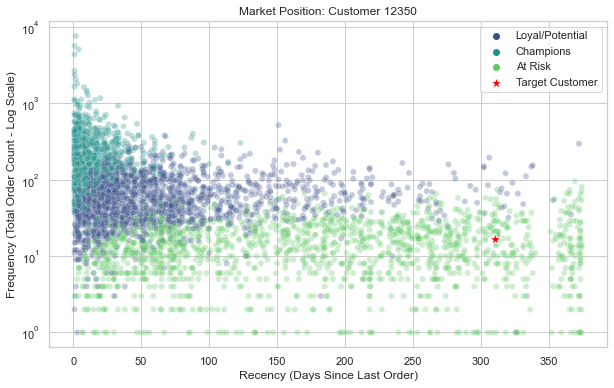

In [37]:
#--------- Example of identifying At Risk customer how doesn't shop often --------

# These customers have a high recency score, meaning they have not made a purchase in a long time

generate_customer_report(12350)

### VIP Recognition:
__Customer 12347__ is a __"Champion"__ who shopped just 2 days ago. The system recommends __Jumbo Bags and Lunch Bags__, which are high-volume items they are likely to need again soon.

--- Behavioral Profile for Customer 12347 ---
Assigned Segment: Champions
Last Purchase: 2 days ago
Total Transactions: 182
Lifetime Value: $4310.00

--- Next-Best-Offer Recommendations ---
1. WHITE HANGING HEART T-LIGHT HOLDER
2. JUMBO BAG RED RETROSPOT
3. REGENCY CAKESTAND 3 TIER
4. LUNCH BAG RED RETROSPOT
5. PARTY BUNTING


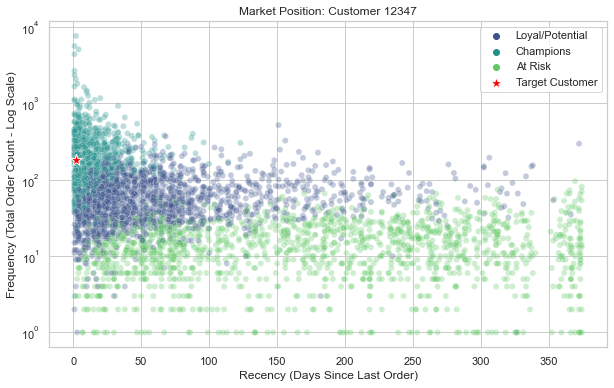

In [38]:
# -------- Example of identifying customer who shop very often ---------

# These customers consists of high-value, frequent buyers

generate_customer_report(12347)

### Strategic Visualization: 
The scatter plots highlight the specific customer as a red star against the backdrop of the entire population, providing immediate context on whether they are trending toward a higher or lower value segment.

--- Behavioral Profile for Customer 12346 ---
Assigned Segment: Loyal/Potential
Last Purchase: 326 days ago
Total Transactions: 1
Lifetime Value: $77183.60

--- Next-Best-Offer Recommendations ---
1. WHITE HANGING HEART T-LIGHT HOLDER
2. REGENCY CAKESTAND 3 TIER
3. ASSORTED COLOUR BIRD ORNAMENT
4. PARTY BUNTING
5. JUMBO BAG RED RETROSPOT


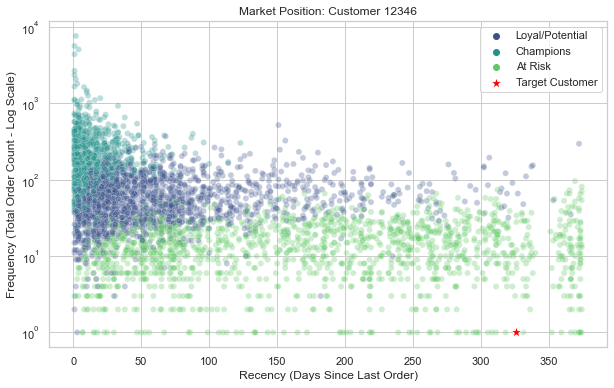

In [39]:
#-------- Example of identifying Loyal customer -------------

#  These are typical retail consumers with moderate spending and occasional visits.

generate_customer_report(12346)